In [48]:
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.cm as cm
import random
import seaborn as sns
random.seed(30)

from matplotlib import pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from numpy.polynomial.polynomial import polyfit
import numpy as np
from scipy.stats import binom_test
from scipy.stats import binom
import seaborn as sns
import datetime
from scipy import optimize


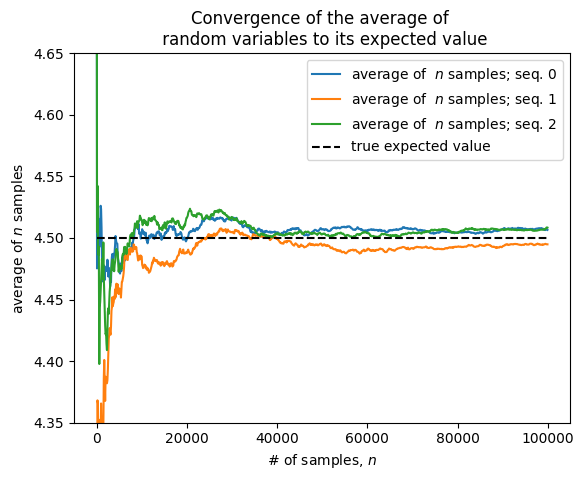

In [39]:

# set up the ground truth
sample_size = 100000
expected_value = lambda_ = 4.5
poi = np.random.poisson
N_samples = range(1, sample_size, 100)

for k in range(3):
    samples = poi(lambda_, sample_size)

    partial_average = [samples[:i].mean() for i in N_samples]

    plt.plot(N_samples, partial_average, lw=1.5, label="average \
of  $n$ samples; seq. %d" % k)

plt.plot(N_samples, expected_value * np.ones_like(partial_average),
         ls="--", label="true expected value", c="k")

plt.ylim(4.35, 4.65)
plt.title("Convergence of the average of \n random variables to its \
expected value")
plt.ylabel("average of $n$ samples")
plt.xlabel("# of samples, $n$")
plt.legend()
plt.show()

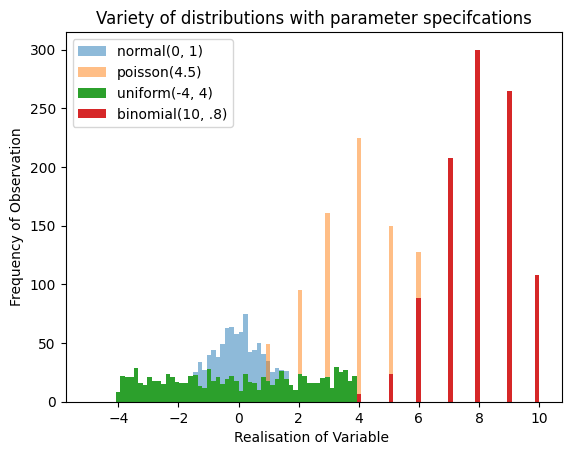

In [40]:
import random
normal = np.random.normal(0, 1, 1000)
poisson = np.random.poisson(4.5, 1000)
uniform = np.random.uniform(-4, 4, 1000)
binomial = np.random.binomial(10, .8, 1000)

bins = np.linspace(-5, 10, 100)

plt.hist(normal, bins, alpha=0.5, label='normal(0, 1)')
plt.hist(poisson, bins, alpha=0.5, label='poisson(4.5)')
plt.hist(uniform, bins, label='uniform(-4, 4)')
plt.hist(binomial, bins, label='binomial(10, .8)')
plt.legend(loc='upper left')
plt.title("Variety of distributions with parameter specifcations")
plt.xlabel("Realisation of Variable ")
plt.ylabel("Frequency of Observation")
plt.show()


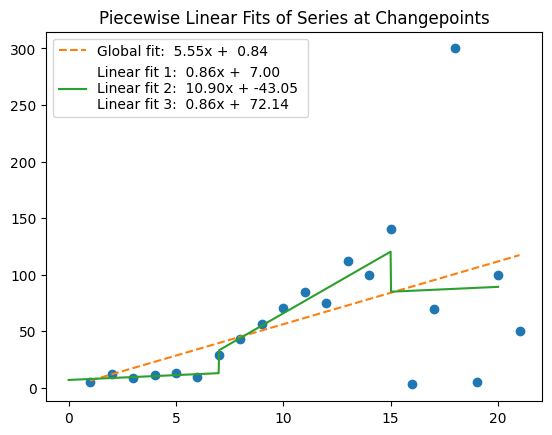

In [43]:
### Piecewise Linear Fits

x = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21],  dtype=float)
y = np.array([5, 12, 9, 11, 13, 10,
              28.92, 42.81, 56.7, 70.59, 84.47, 75.36, 112.25, 100.14, 140.03, 3, 70, 300, 5, 100, 50], dtype=float)

def piecewise_linear(x, b1, a1,  b2, a2, b3, a3):
    funcs = [lambda x:b1*x + a1,
             lambda x:b2*x + a2,
             lambda x:b3*x + a3]
    conds = [x < 7, ((x >= 7) & (x < 15)), x > 15]
    return np.piecewise(x, conds, funcs)

p , e = optimize.curve_fit(piecewise_linear, x, y, method="trf")
a, b = polyfit(x, y, 1)
xd = np.linspace(0, 20, 1000)

plt.plot(x, y, "o")
plt.plot(x, a + b * x, '--', label="Global fit: {b: .2f}x + {a: .2f}".format(b=b, a=a))
plt.plot(xd, piecewise_linear(xd, *p), label="Linear fit 1: {b: .2f}x + {a: .2f} \n"
                                             "Linear fit 2: {b1: .2f}x + {a1: .2f} \n"
                                             "Linear fit 3: {b2: .2f}x + {a2: .2f}".format(b=p[0], a=p[1],
                                                                                          b1=p[2], a1=p[3],
                                                                                          b2=p[4], a2=p[5]))
plt.title("Piecewise Linear Fits of Series at Changepoints")
plt.legend()
plt.show()


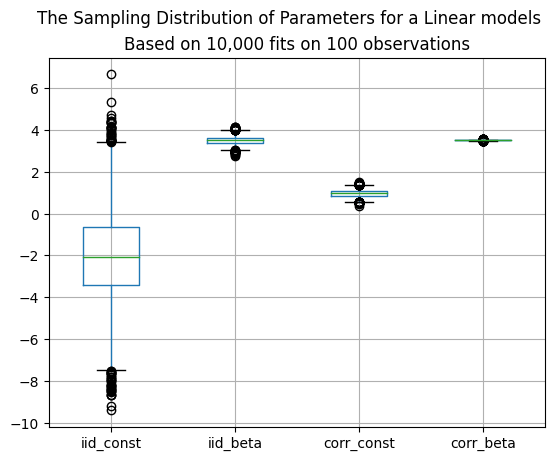

In [44]:
#### Sampling Distributions of Linear Fits
#### Build True Model
N = 100000
X = np.random.uniform(0, 20, N)
uncorrelated_errors = np.random.normal(0, 10, N)
correlated_errors = np.random.uniform (0, 10) + np.sin(np.linspace(0, 10*np.pi, N)) \
          + np.sin(np.linspace(0, 5*np.pi, N))**2 \
          + np.sin(np.linspace(1, 6*np.pi, N))**2

Y_corr = -2 + 3.5 * X + correlated_errors
Y = -2 + 3.5 * X + uncorrelated_errors
population = pd.DataFrame({'X': X, 'Y': Y, 'Y_corr': Y_corr})

fits = pd.DataFrame(columns=['iid_const', 'iid_beta', 'corr_const', 'corr_beta'])
for i in range(0, 10000):
    sample = population.sample(n=100, replace=True)
    Y = sample['Y']; X = sample['X'] ; Y_corr = sample['Y_corr']
    X = sm.add_constant(X)
    iid_model = sm.OLS(Y, X)
    results = iid_model.fit()
    corr_model = sm.OLS(Y_corr, X)
    results_2 = corr_model.fit()
    row = [results.params[0], results.params[1], results_2.params[0], results_2.params[1]]
    fits.loc[len(fits)] = row


fits.boxplot()
plt.suptitle("The Sampling Distribution of Parameters for a Linear models")
plt.title("Based on 10,000 fits on 100 observations")
plt.show()


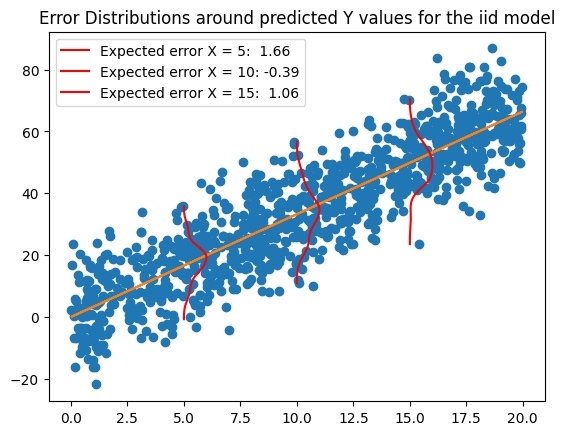

In [49]:

def draw_gaussian_at(position, sample, ax_main=None, model='iid', color='k', **kwargs):
    filter_var = round(sample['X'], 0) == position
    avg = sample[filter_var]['predicted_Y_' + model].mean()
    min = sample[filter_var]['Y'].min()
    max = sample[filter_var]['Y'].max()
    dist = pd.Series(sample[filter_var]['predicted_error_'+ model].values)
    kde = sm.nonparametric.KDEUnivariate(dist)
    kde.fit()
    density = kde.density
    density /= density.max()
    density *= 1
    y_axis = np.linspace(min, max, len(density))
    label = "Expected error X = {x:}: {err: .2f}".format(err = sample[filter_var]['predicted_error_'+ model].mean(),
                                                         x=position)
    ax_main.plot((density + position), y_axis, color=color, label=label)

sample = population.sample(n=1000, replace=True, random_state=100)
true_model = sm.OLS(sample['Y'], sample['X']).fit()
error_model = sm.OLS(sample['Y_corr'], sample['X']).fit()
sample['predicted_Y_iid'] = true_model.predict(sample['X'])
sample['predicted_Y_corr'] = error_model.predict(sample['X'])
sample['predicted_error_iid'] = sample['Y'] - sample['predicted_Y_iid']
sample['predicted_error_corr'] = sample['Y'] - sample['predicted_Y_corr']
fig, ax1 = plt.subplots()
ax1.plot(sample['X'], sample['Y'],'o')
ax1.plot(sample['X'], sample['predicted_Y_iid'])
for each in [5, 10,  15]:
    d = draw_gaussian_at(position=each, sample=sample, ax_main=ax1, model='iid', color='r')
plt.title("Error Distributions around predicted Y values for the {model:}".format(model='iid model'))
plt.legend()
plt.show()



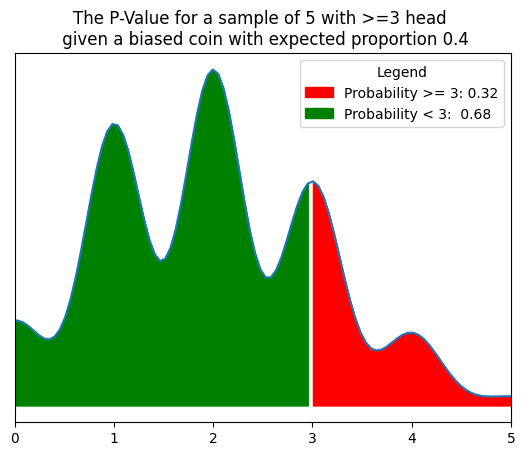

In [46]:
#### Set up p-value Plot

samples = 5
prop = 0.4
successes = 3

X = stats.binom(samples, prop)
x = X.rvs(1000)
points = sns.distplot(x, hist=False, kde=True).get_lines()[0].get_data()

prob = 1 - X.cdf(2)

z = points[0]
y = points[1]
plt.fill_between(z,y, where = z >= successes, color='r', label="Probability >= 3:{p: .2f}".format(p=prob))
plt.fill_between(z,y, where = z < successes , color='g',
                 label="Probability < 3: {mean: .2f}".format(mean=1-prob))
plt.legend(loc='upper right', title='Legend')
plt.title("The P-Value for a sample of 5 with >=3 head \n given a biased coin with expected proportion 0.4")
plt.xlim((0, 5))
plt.yticks([])
plt.show()


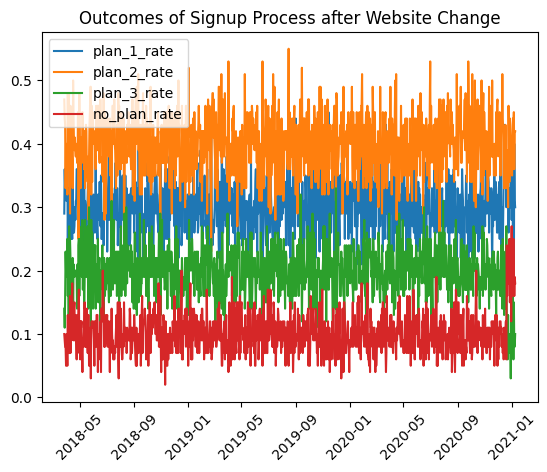

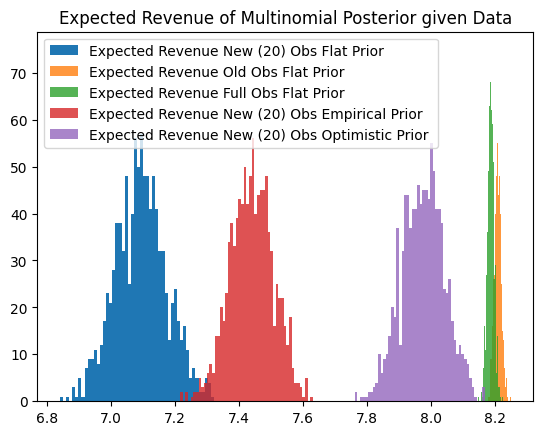

In [47]:
### Multinomial distribution

m_var = stats.multinomial(n=100, p=[.3, .4, .2, .1])
m_var_sample = m_var.rvs(1000)
m_var_2 = stats.multinomial(n=100, p=[.3, .4, .1, .2])
m_var_2_sample = m_var_2.rvs(20)
base = datetime.datetime.today() - datetime.timedelta(days=1000)
df = pd.DataFrame(m_var_sample, columns=['plan_1', 'plan_2', 'plan_3', 'no_plan'])
df = df.append(pd.DataFrame(m_var_2_sample, columns=['plan_1', 'plan_2', 'plan_3', 'no_plan']),
               ignore_index=True)
df['totals'] = df['plan_1'] + df['plan_2'] + df['plan_3'] + df['no_plan']
df['plan_1_rate'] = df['plan_1'] / df['totals']
df['plan_2_rate'] = df['plan_2'] / df['totals']
df['plan_3_rate'] = df['plan_3'] / df['totals']
df['no_plan_rate'] = df['no_plan'] / df['totals']
date_list = [base + datetime.timedelta(days=x) for x in range(len(df))]
df.index = date_list
for i, column in enumerate([x for x in df.columns if 'rate' in x]):
    ax = plt.plot(df[column], label=column)

plt.title("Outcomes of Signup Process after Website Change")
plt.legend(loc="upper left")
plt.xticks(rotation=45)
plt.show()

#### Calculate Expected Revenue

def expected_revenue(posterior_samples):
    return 10*posterior_samples[:, 0] + 7*posterior_samples[:, 1] + \
           12*posterior_samples[:, 2] + 0*posterior_samples[:, 3]

full_data = df[['plan_1', 'plan_2', 'plan_3', 'no_plan']]
weird_data2 = df[['plan_1', 'plan_2', 'plan_3', 'no_plan']].tail(20)
normal_data = df[['plan_1', 'plan_2', 'plan_3', 'no_plan']].head(1000)

# Bayesian Posterior
multinomial_posterior_new = np.random.dirichlet(np.array([100, 100, 100, 100]) +
                                                 np.array(weird_data2.sum()), size=1000)

# Empirical Bayes
multinomial_posterior_full = np.random.dirichlet(np.array([100, 100, 100, 100]) + np.array(full_data.sum()), size=1000)

# Bayesain Posterior Prior Data

multinomial_posterior_old = np.random.dirichlet(np.array([100, 100, 100, 100]) + np.array(normal_data.sum()), size=1000)

multinomial_posterior_new_empirical_prior = np.random.dirichlet(np.array([300, 400, 200, 100]) +
                                                 np.array(weird_data2.sum()), size=1000)

multinomial_posterior_crazy_prior = np.random.dirichlet(np.array([100, 400, 500, 0]) +
                                                 np.array(weird_data2.sum()), size=1000)


expected_value_new = expected_revenue(multinomial_posterior_new)
expected_value_old = expected_revenue(multinomial_posterior_old)
expected_value_full_data = expected_revenue(multinomial_posterior_full)
expected_value_new_bias = expected_revenue(multinomial_posterior_new_empirical_prior)
expected_value_crazy = expected_revenue(multinomial_posterior_crazy_prior)

plt.hist(expected_value_new, histtype='stepfilled', label="Expected Revenue New (20) Obs Flat Prior", bins=50)
plt.hist(expected_value_old, histtype='stepfilled', label="Expected Revenue Old Obs Flat Prior", bins=50, alpha=0.8)
plt.hist(expected_value_full_data, histtype='stepfilled', label="Expected Revenue Full Obs Flat Prior", bins=50, alpha=0.8)
plt.hist(expected_value_new_bias, histtype='stepfilled', label="Expected Revenue New (20) Obs Empirical Prior ", bins=50, alpha=0.8)
plt.hist(expected_value_crazy, histtype='stepfilled', label="Expected Revenue New (20) Obs Optimistic Prior ", bins=50, alpha=0.8)
plt.title("Expected Revenue of Multinomial Posterior given Data")
plt.legend(loc="upper left")
plt.show()


## Utility Curves

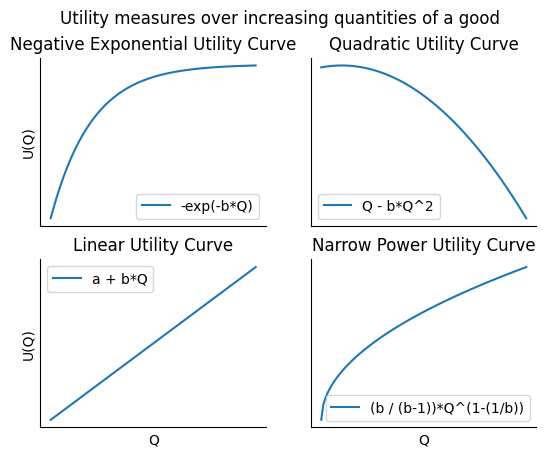

In [30]:

def linear_utility(x, a=2, b=4):
    # This works fine on smaller numbers
    return a + b*x

def quadriatic_utility(x, b=0.5):
    return x - (b)*(x**2)

def logarithmic_utility(x, a, b):
    return np.log(a) + b*np.log(x)

def negative_exp_utility(x, c=.5):
    return -np.exp(-(c*x))

def narrow_power(x, B=2):
    return (B / (B - 1))*(x**(1 - (1/B)))

xdata = np.linspace(0, 10, 100)
negExp = negative_exp_utility(xdata, 0.5)
quad = quadriatic_utility(xdata, 0.5)
narrow_pow = narrow_power(xdata, 2)
lin = linear_utility(xdata, 2, 3)

# Create plot
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)

ax0.plot(xdata, negExp, label="-exp(-b*Q)")
ax0.set_title("Negative Exponential Utility Curve")
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_ylabel("U(Q)")
ax0.legend()
ax0.titlesize = 10

ax1.plot(xdata, quad, label="Q - b*Q^2")
ax1.set_title("Quadratic Utility Curve")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.legend()

ax2.plot(xdata, lin, label="a + b*Q")
ax2.set_title("Linear Utility Curve")
ax2.set_yticks([])
ax2.set_xticks([])
ax2.set_ylabel("U(Q)")
ax2.set_xlabel("Q")
ax2.legend()

ax3.plot(xdata, narrow_pow, label="(b / (b-1))*Q^(1-(1/b))")
ax3.set_title("Narrow Power Utility Curve")
ax3.set_yticks([])
ax3.set_xticks([])
ax3.set_xlabel("Q")
ax3.legend()

for _ax in [ax0, ax1, ax2, ax3]:
    _ax.spines["right"].set_visible(False)
    _ax.spines["top"].set_visible(False)

fig.suptitle("Utility measures over increasing quantities of a good")
plt.show()


/Users/nathanielforde/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


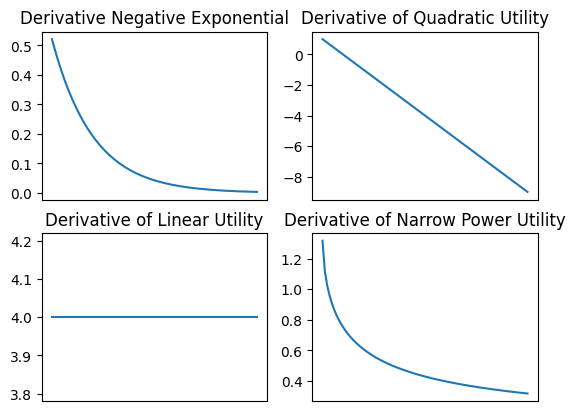

In [31]:

from scipy.misc import derivative

# Create plot
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2)

derivs = [derivative(negative_exp_utility,x) for x in xdata]
ax0.plot(xdata,derivs , label="Derivative of Negative Exponential")
ax0.set_title("Derivative Negative Exponential")
ax0.set_xticks([])

derivs2 = [derivative(quadriatic_utility, x) for x in xdata]
ax1.plot(xdata,derivs2, label="Derivative of Quadratic Curve")
ax1.set_title("Derivative of Quadratic Utility")
ax1.set_xticks([])

derivs3 = [derivative(linear_utility, x) for x in xdata]
ax2.plot(xdata,derivs3)
ax2.set_title("Derivative of Linear Utility")
ax2.set_xticks([])

derivs4 = [derivative(narrow_power, x) for x in xdata]
ax3.plot(xdata, derivs4)
ax3.set_title("Derivative of Narrow Power Utility")
ax3.set_xticks([])

plt.show()

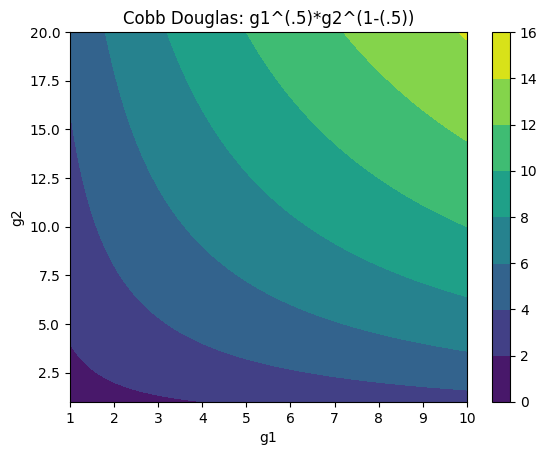

In [32]:
def cobb_douglas(g1, g2, a1, a2):
    return g1**a1 * g2**a2


fig, ax = plt.subplots()
g1 = np.linspace(1, 10, 100)
g2 = np.linspace(1, 20, 100).reshape((100, 1))
contours = ax.contourf(g1, g2.flatten(), cobb_douglas(g1, g2, .5, .5))
fig.colorbar(contours)
ax.set_xlabel("g1")
ax.set_ylabel("g2")
ax.set_title("Cobb Douglas: g1^(.5)*g2^(1-(.5))")
plt.show()

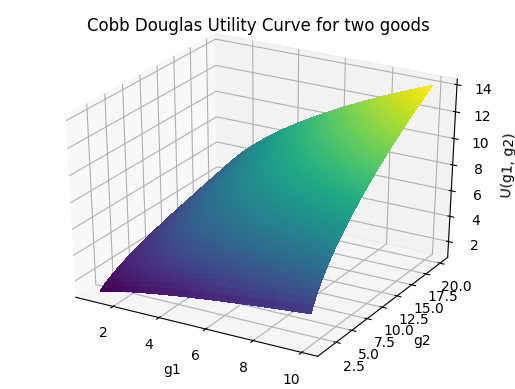

In [33]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
g1, g2 = np.meshgrid(g1, g2)
U = cobb_douglas(g1, g2, .5, .5)

# Plot the surface.
surf = ax.plot_surface(g1, g2, U, cmap=cm.viridis,
                       linewidth=0, antialiased=False)
ax.set_xlabel('g1')
ax.set_ylabel('g2')
ax.set_zlabel('U(g1, g2)')
plt.title("Cobb Douglas Utility Curve for two goods")
plt.show()


## Indifference Curves

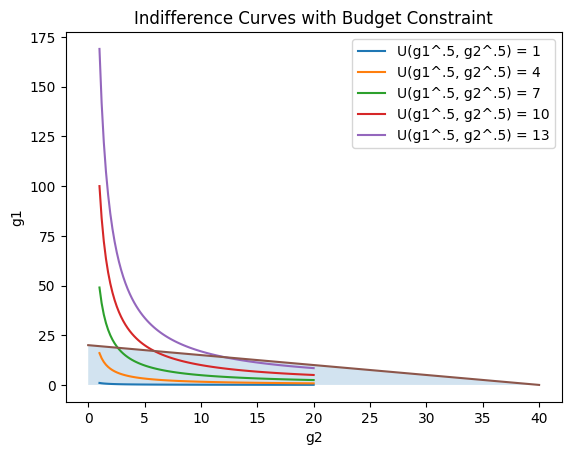

In [34]:
g1 = np.linspace(1, 10, 100)
g2 = np.linspace(1, 20, 100).reshape((100, 1))
def g1_indifference(g2, k, alpha=1/3):
    orig = k**(1/(1-alpha)) * g2**(-alpha/(1-alpha))
    return orig

def plot_indifference_curves(ax, alpha=.5):
    k = np.arange(1, 14, 3)
    ax.plot(g2, g1_indifference(g2, k, alpha))
    ax.legend(["U(g1^.5, g2^.5)" + " = {}".format(i) for i in k])
    ax.set_xlabel("g2")
    ax.set_ylabel("g1 ")
    plt.title("Indifference Curves with Budget Constraint")

def budget(B, W=50, pa=2):
    "Given B, W, and pa return the max amount of A our consumer can afford"
    return (W - B) / pa

def plot_budget_constraint(ax, W=40, pa=2):
    g2 = np.array([0, W])
    g1 = budget(g2, W, pa)
    ax.plot(g2, g1)
    ax.fill_between(g2, 0, g1, alpha=0.2)
    ax.set_xlabel("g2")
    ax.set_ylabel("g1")
    return ax


fig, ax = plt.subplots()
plot_indifference_curves(ax)
plot_budget_constraint(ax)


In [35]:
from scipy.optimize import minimize_scalar
def objective(B, W=40, pa=2):
    """
    Return value of -U for a given B, when we consume as much A as possible

    Note that we return -U because scipy wants to minimize functions,
    and the value of B that minimizes -U will maximize U
    """
    A = budget(B, W, pa)
    return -cobb_douglas(A, B, .5, .5)

result = minimize_scalar(objective)
optimal_B = result.x
optimal_A = budget(optimal_B, 40, 2)
optimal_U = cobb_douglas(optimal_A, optimal_B, .5, .5)

print("The optimal U is ", optimal_U)
print("and was found at (A,B) =", (optimal_A, optimal_B))


The optimal U is  14.14213562373095
and was found at (A,B) = (9.999999999693332, 20.000000000613337)


In [38]:
from sympy import solve, symbols, Eq
g1, g2, l = symbols('g1 g2 l')

solution = solve([Eq((1/2)*(g1**(-1/2))*(g2**(1/2)) - 2*l, 0),
   Eq((1/2)*(g2**(-1/2))*(g1**(1/2)) - 3*l, 0),
   Eq(2*g1+3*g2 - 40, 0)],[g1,g2,l], simplify=False)
solution

[(10.0000000000000, 6.66666666666667, 0.204124145231932)]

## Customer Purchase Data

In [61]:
X, y = make_blobs(n_samples=10000, centers=5, n_features=6,
                 random_state=0)

df_products = pd.DataFrame(data=X,
                           columns=['product_desc_' + str(x) for x in range(0, 6)])
df_products['Product_Class'] = y
df_products['Product_ID'] = df_products.index

X, y = make_blobs(n_samples=1000, centers=10, n_features=8,
                 random_state=0)

df_customer = pd.DataFrame(data=X,
                           columns=['customer_desc_' + str(x) for x in range(0, 8)])

df_customer['Customer_Class'] = y
df_customer['Customer_ID'] = df_customer.index

day1 = pd.DataFrame(zip([random.randint(0, 1000) for x in range(0, 500)],
                [random.randint(0, 10000) for x in range(0, 500)]), columns=['Customer_ID', 'Product_ID'])

day2 = pd.DataFrame(zip([random.randint(0, 1000) for x in range(0, 500)],
                [random.randint(0, 10000) for x in range(0, 500)]), columns=['Customer_ID', 'Product_ID'])

purchases = pd.concat([day1, day2], axis=0, ignore_index=True)

df_purchases = None
for purchase in range(0, len(purchases)):
    cust_id = purchases['Customer_ID'][purchase]
    prod_id = purchases['Product_ID'][purchase]
    cust_features = df_customer[df_customer['Customer_ID'] == cust_id]
    cust_features.reset_index(inplace=True)
    prod_features = df_products[df_products['Product_ID'] == prod_id]
    prod_features.reset_index(inplace=True)
    temp = pd.concat([prod_features, cust_features], axis=1)
    if df_purchases is None:
        df_purchases = pd.concat([prod_features, cust_features], axis=1)
    else:
        df_purchases = df_purchases.append(pd.concat([prod_features, cust_features], axis=1))
df_purchases.reset_index(inplace=True)
df_purchases

,level_0,index,product_desc_0,product_desc_1,product_desc_2,product_desc_3,product_desc_4,product_desc_5,Product_Class,Product_ID,...,customer_desc_0,customer_desc_1,customer_desc_2,customer_desc_3,customer_desc_4,customer_desc_5,customer_desc_6,customer_desc_7,Customer_Class,Customer_ID
0,0,773,-1.233276,8.747108,9.165746,-0.007541,4.652380,1.913970,1,773,...,-6.374916,-2.257586,7.688019,-7.992522,7.593467,-9.193683,10.376847,-0.388405,8.0,552.0
1,0,8608,-0.170403,8.219852,9.710727,-1.550177,5.811414,1.492459,1,8608,...,9.294317,-2.231715,6.061894,-0.438840,1.246116,8.820684,-9.950039,-7.391761,1.0,827.0
2,0,518,-2.822567,8.036298,10.929105,-0.935760,6.077699,1.265250,1,518,...,-8.793580,4.805865,6.167272,5.770659,7.451190,4.144325,1.196351,5.414350,2.0,296.0
3,0,5394,1.019780,6.766354,-9.152836,-8.611808,-8.749707,6.637419,2,5394,...,-7.047638,-2.131113,5.768863,-8.094387,6.223832,-8.834962,9.629384,-1.935227,8.0,625.0
4,0,8543,4.321656,7.430975,8.847703,5.921750,-0.868445,5.483210,3,8543,...,-0.169121,1.346768,-10.211423,1.709859,1.655568,1.891809,7.856076,4.333816,4.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,8383,2.151425,3.179085,2.337353,0.559543,-1.629433,2.493002,0,8383,...,-4.926378,-1.474424,2.848533,-10.733950,4.237231,5.048239,-5.263423,-7.005510,5.0,272.0
996,0,6141,0.475735,4.378010,2.597665,1.569648,-1.131376,3.110801,0,6141,...,7.821350,-1.948967,6.039587,1.739432,2.351800,8.325224,-10.263796,-7.450850,1.0,616.0
997,0,406,4.621406,7.791088,8.592775,6.423716,0.915721,4.727899,3,406,...,-9.236352,2.760513,-7.290240,9.169618,-0.188279,-2.443252,-4.153840,6.140598,3.0,266.0
998,0,9737,-1.720297,8.174031,9.746428,-1.849028,5.046019,0.951072,1,9737,...,-1.411479,0.830250,5.167232,-9.188249,3.176105,4.570698,-6.300042,-7.561958,5.0,263.0


## A Clustering Scheme

/Users/nathanielforde/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


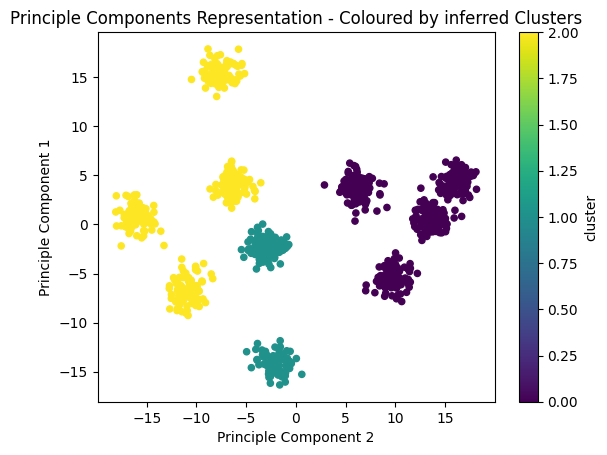

In [62]:
X = df_customer[[x for x in df_purchases.columns if 'customer_desc' in x]]
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=30)
kmeans.fit(X)
clusters = kmeans.predict(X)
X['cluster'] = clusters
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components=2)
Y_pca = pd.DataFrame(sklearn_pca.fit_transform(X[[col for col in X.columns if
                                         not 'cluster' in col]]))
X = pd.concat([X, Y_pca], axis=1)
X[[0, 1, 'cluster']].plot.scatter(x=0,
                      y=1,
                      c='cluster',
                      colormap='viridis')
plt.title("Principle Components Representation - Coloured by inferred Clusters")
plt.ylabel("Principle Component 1")
plt.xlabel("Principle Component 2")
plt.style.use('default')
plt.show()

## PCA and Explained Variance

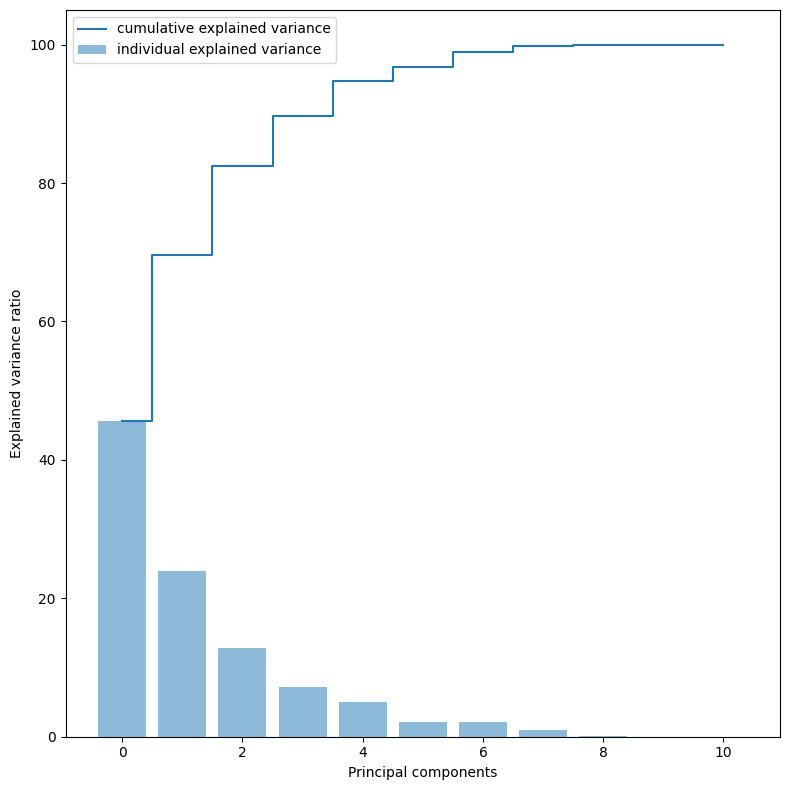

In [63]:
X_std = StandardScaler().fit_transform(X)
## Covariance Decomposition
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

## Explained Variance
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(8, 8))

plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.style.use('default')

## Weighting of Eigenvectors

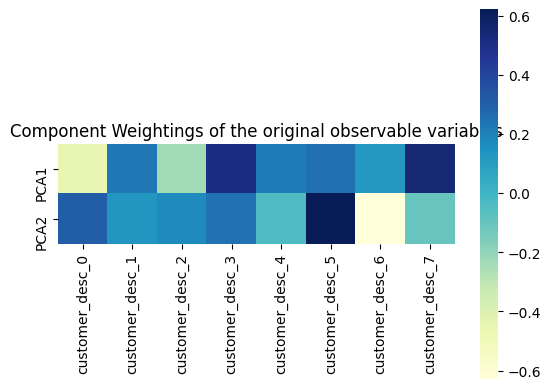

In [65]:
ax = sns.heatmap(sklearn_pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,sklearn_pca.n_components_+1)],
                 xticklabels=['customer_desc_0', 'customer_desc_1', 'customer_desc_2',
       'customer_desc_3', 'customer_desc_4', 'customer_desc_5',
       'customer_desc_6', 'customer_desc_7'],
                 #cbar_kws={"orientation": "horizontal"}
                 )
ax.set_aspect("equal")
plt.title("Component Weightings of the original observable variables")
plt.style.use('default')

## Check the Silhouette Scores

In [66]:
matrix = df_purchases[[x for x in df_purchases.columns if 'product_desc' in x]]
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 3 The average silhouette_score is : 0.6493890697456468
For n_clusters = 4 The average silhouette_score is : 0.6451512654359808
For n_clusters = 5 The average silhouette_score is : 0.7463263413202564
For n_clusters = 6 The average silhouette_score is : 0.6212637147208637
For n_clusters = 7 The average silhouette_score is : 0.5017386136426956
For n_clusters = 8 The average silhouette_score is : 0.3754304307025587
For n_clusters = 9 The average silhouette_score is : 0.2563979721008551


In [67]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10
    plt.title('Silhouette Scores per Cluster')


In [68]:
best_kmeans = KMeans(init='k-means++', n_clusters=3, n_init=30)
best_kmeans.fit(matrix)
best_clusters = best_kmeans.predict(matrix)

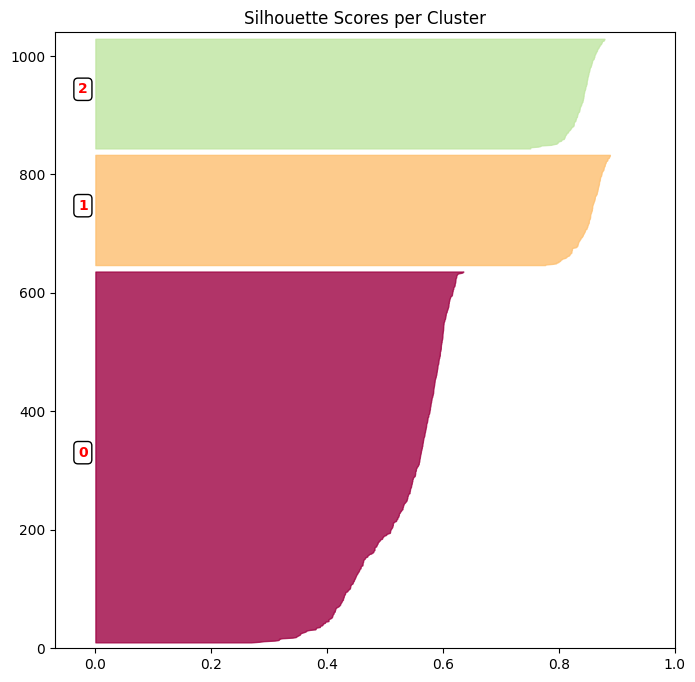

In [69]:
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, best_clusters)

# and do the graph
graph_component_silhouette(3, [-0.07, 1], len(X), sample_silhouette_values, best_clusters)